In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
DATA_PATH = "C:/Users/Rishi/Desktop/project/Indian-Sign-Language-Recognition-System/data_images"

In [3]:
# Get the list of directories
categories = sorted(os.listdir(DATA_PATH))
print(f"Categories: {categories}")

Categories: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'delete', 'space']


In [4]:
# Function to load images and labels using OpenCV
def load_images_and_labels(data_path, categories, img_size=(64, 64)):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(data_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(category)
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(DATA_PATH, categories)

In [5]:

label_counts = pd.Series(labels).value_counts().sort_index()
fig = px.bar(label_counts, title="Distribution of Images per Class")
fig.show(renderer="browser")

In [6]:
# Encode labels
label_binarizer = LabelBinarizer()
labels_encoded = label_binarizer.fit_transform(labels)

In [7]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

In [8]:
# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)

In [10]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
475/475 [==============================] - 64s 131ms/step - loss: 2.9747 - accuracy: 0.1870 - val_loss: 2.7284 - val_accuracy: 0.3076
Epoch 2/20
475/475 [==============================] - 64s 135ms/step - loss: 1.4399 - accuracy: 0.5902 - val_loss: 0.8104 - val_accuracy: 0.7813
Epoch 3/20
475/475 [==============================] - 61s 128ms/step - loss: 0.9527 - accuracy: 0.7346 - val_loss: 0.5178 - val_accuracy: 0.8447
Epoch 4/20
475/475 [==============================] - 60s 126ms/step - loss: 0.7565 - accuracy: 0.7872 - val_loss: 0.4245 - val_accuracy: 0.8745
Epoch 5/20
475/475 [==============================] - 59s 124ms/step - loss: 0.6429 - accuracy: 0.8175 - val_loss: 0.2259 - val_accuracy: 0.9329
Epoch 6/20
475/475 [==============================] - 60s 126ms/step - loss: 0.5723 - accuracy: 0.8371 - val_loss: 0.2849 - val_accuracy: 0.9242
Epoch 7/20
475/475 [==============================] - 61s 129ms/step - loss: 0.5038 - accuracy: 0.8584 - val_loss: 0.2023 - val_ac

In [12]:
# Evaluate the model
y_pred = model.predict(X_test)
y_test_labels = label_binarizer.inverse_transform(y_test)
y_pred_labels = label_binarizer.inverse_transform(y_pred)

119/119 [==============================] - 5s 29ms/step


In [13]:
# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=categories)

fig_cm = px.imshow(
    cm,
    x=categories,
    y=categories,
    title='Confusion Matrix',
    color_continuous_scale='Blues',
    text_auto=True
)

fig_cm.update_layout(
    xaxis_title='Predicted Label',
    yaxis_title='True Label'
)

# Render in browser instead of inline (avoids nbformat requirement)
fig_cm.show(renderer="browser")

In [14]:
epochs = list(range(1, len(history.history['loss']) + 1))

fig_loss = px.line(
    x=epochs, 
    y=history.history['loss'], 
    labels={'x': 'Epoch', 'y': 'Loss'}, 
    title='Training Loss'
)
fig_loss.add_scatter(x=epochs, y=history.history['val_loss'], mode='lines', name='Validation Loss')
fig_loss.show(renderer="browser")

fig_acc = px.line(
    x=epochs, 
    y=history.history['accuracy'], 
    labels={'x': 'Epoch', 'y': 'Accuracy'}, 
    title='Training Accuracy'
)
fig_acc.add_scatter(x=epochs, y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy')
fig_acc.show(renderer="browser")


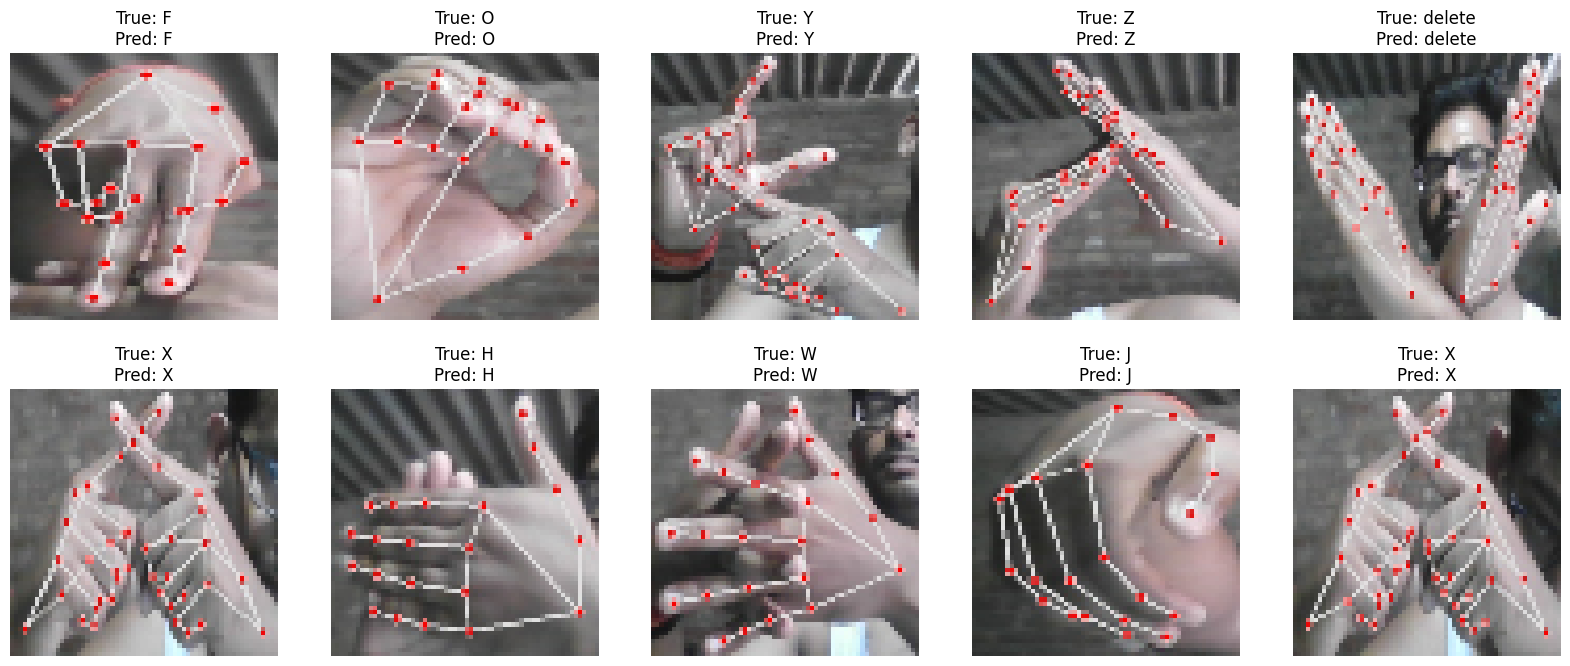

In [15]:
# Display 10 sample predictions
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i])
    true_label = label_binarizer.inverse_transform(np.array([y_test[i]]))[0]
    pred_label = y_pred_labels[i]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis('off')
plt.show()

In [16]:
# Save the model
model.save("sign_language_model.h5")

c:\Users\Rishi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [17]:
# Check for overfitting by comparing training and validation loss/accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

if val_loss[-1] > train_loss[-1] and val_acc[-1] < train_acc[-1]:
    print("The model might be overfitting. Consider using regularization techniques or early stopping.")
else:
    print("The model does not seem to be overfitting.")

The model does not seem to be overfitting.
